In [12]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [92]:
import pandas as pd

dfs = {
    2019: pd.read_csv('final2019.csv'),
    2020: pd.read_csv('final2020.csv'),
    2021: pd.read_csv('final2021.csv'),
    2022: pd.read_csv('final2022.csv'),
    2023: pd.read_csv('final2023.csv'),
}

for year, df in dfs.items():
    print(f"--- Colonnes {year} ---")
    print(df.columns.tolist(), "\n")

/tmp/ipykernel_10637/1594908137.py:4: DtypeWarning: Columns (7,8,20,22,24,26,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2019: pd.read_csv('final2019.csv'),
/tmp/ipykernel_10637/1594908137.py:5: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  2020: pd.read_csv('final2020.csv'),
/tmp/ipykernel_10637/1594908137.py:6: DtypeWarning: Columns (7,8,20,22,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2021: pd.read_csv('final2021.csv'),
/tmp/ipykernel_10637/1594908137.py:7: DtypeWarning: Columns (7,8,20,22,24,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2022: pd.read_csv('final2022.csv'),
/tmp/ipykernel_10637/1594908137.py:8: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  2023: pd.read_csv('final2023.csv'),


--- Colonnes 2019 ---
['Date_établissement_DPE', 'Etiquette_DPE', 'Type_bâtiment', 'Année_construction', 'Période_construction', 'Surface_habitable_logement', 'Adresse_(BAN)', 'N°_département_(BAN)', 'Code_INSEE_(BAN)', 'Adresse_Normalisee', 'id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', 'valeur_fonciere', 'adresse_numero', 'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune', 'nom_commune', 'code_departement', 'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale', 'surface_terrain', 'longitude', '

In [128]:
# 1) Concaténation
df = pd.concat(dfs.values(), ignore_index=True)
print("Shape après concaténation :", df.shape)

Shape après concaténation : (574251, 53)


In [159]:
import pandas as pd

# 1) Concaténation
df = pd.concat(dfs.values(), ignore_index=True)
print("Shape après concaténation :", df.shape)

# 2) Date → datetime + extraction de l'année
df['date_mutation'] = pd.to_datetime(df['date_mutation'], errors='coerce')
df['year'] = df['date_mutation'].dt.year

Shape après concaténation : (574251, 53)


# code pour changer les groupes traités//de contrôle

In [160]:
# 1) Nettoyage de la variable DPE
df['dpe_clean'] = df['Etiquette_DPE'].str.upper().str.strip()

# 2) Création de l'indicatrice de traitement
# Le groupe de traitement est constitué des logements avec une étiquette DPE F ou G.
df['treat'] = df['dpe_clean'].isin(['F', 'G']).astype(int)
#A activer si on veut filtrer par maison ou appartement
df = df[df['Type_bâtiment'] == 'maison']

# 3) Définir l'indicateur 'post' qui vaut 1 si la date de mutation est postérieure à la date clé, sinon 0.
df['post_exact'] = (df['date_mutation'] >= '2021-08-24').astype(int)

# 4) Création de l'indicatrice DID qui est le produit de 'treat' et 'post_exact'
# Cette variable identifie les observations du groupe traité après la période de l'intervention.
df['did'] = df['treat'] * df['post_exact']

# 5) Création de l'indicatrice de groupe de contrôle (0 pour A, B, C, D, 1 pour F, G)
# Le groupe de contrôle est constitué des logements avec une étiquette DPE A, B, C ou D
df['control'] = df['dpe_clean'].isin([ 'A','B','C','D']).astype(int)
# On restreint aux DPE A, B, C, E, F, G uniquement
df = df[df['dpe_clean'].isin(['A', 'B', 'C', 'D', 'F', 'G'])]
#



In [ ]:
#pour vérifier qu'on a bien les groupes de contrôle/traités qu'on souhaite :

In [161]:
print("Répartition des étiquettes DPE par groupe treat:")
print(df.groupby('treat')['dpe_clean'].value_counts())


Répartition des étiquettes DPE par groupe treat:
treat  dpe_clean
0      D            49461
       C            25442
       B             5517
       A             2978
1      F            18943
       G            11540
Name: count, dtype: int64


In [131]:
print("Répartition des étiquettes DPE par type de bâtiment:")
print(df.groupby('Type_bâtiment')['dpe_clean'].value_counts())

Répartition des étiquettes DPE par type de bâtiment:
Type_bâtiment  dpe_clean
appartement    D            151477
               E            114296
               C             82805
               F             42430
               G             18423
immeuble       D               199
               E               172
               C                96
               F                59
               G                28
maison         D             49461
               E             39623
               C             25442
               F             18943
               G             11540
Name: count, dtype: int64


## Nettoyage des valeurs extrêmes

In [163]:
# Sauvegarde du nombre initial d'observations
n_initial = df.shape[0]

# 1. Filtrage des valeurs extrêmes sur 'valeur_fonciere'
q1_vf = df['valeur_fonciere'].quantile(0.01)
q99_vf = df['valeur_fonciere'].quantile(0.99)
df_filtered = df[(df['valeur_fonciere'] >= q1_vf) & (df['valeur_fonciere'] <= q99_vf)]
n_after_valeur = df_filtered.shape[0]
print(f"Après filtrage des valeurs extrêmes de valeur_fonciere : {n_after_valeur:,} (perte de {n_initial - n_after_valeur:,})")

# 2. Filtrage des valeurs extrêmes sur 'surface_reelle_bati'
q1_surf = df_filtered['surface_reelle_bati'].quantile(0.01)
q99_surf = df_filtered['surface_reelle_bati'].quantile(0.99)
df_filtered = df_filtered[(df_filtered['surface_reelle_bati'] >= q1_surf) & (df_filtered['surface_reelle_bati'] <= q99_surf)]
n_final = df_filtered.shape[0]
print(f"Après filtrage aussi sur surface_reelle_bati : {n_final:,} (perte totale de {n_initial - n_final:,})")

# On remplace le DataFrame d'origine par le filtré pour la suite
df = df_filtered.copy()


Après filtrage des valeurs extrêmes de valeur_fonciere : 107,341 (perte de 2,189)
Après filtrage aussi sur surface_reelle_bati : 105,323 (perte totale de 4,207)


## Régression statique

In [13]:
# Variables utilisées dans la régression
vars_used = ['valeur_fonciere', 'surface_reelle_bati', 'Etiquette_DPE', 
             'Année_construction', 'type_local', 'code_departement']

# Nombre de NA par variable
df_2023[vars_used].isna().sum()


NameError: name 'df_2023' is not defined

In [45]:
# Étape 1 : Créer une variable binaire = 1 si Année_construction est manquante
df_2023['year_const_miss'] = df_2023['Année_construction'].isna().astype(int)

# Étape 2 : Remplacer les NA de Année_construction par 0 (ou autre si tu préfères)
df_2023['Année_construction_imp'] = df_2023['Année_construction'].fillna(0)

# Étape 3 : Tu peux dropper les NA restants sur les autres variables maintenant
df_2023_clean = df_2023.dropna(subset=['valeur_fonciere', 'surface_reelle_bati', 
                                       'Etiquette_DPE', 'type_local', 'code_departement'])


df_2023_clean['Etiquette_DPE'] = pd.Categorical(
    df_2023_clean['Etiquette_DPE'],
    categories=['F', 'G', 'E', 'D', 'C', 'B', 'A'],  # F devient référence
    ordered=True
)



NameError: name 'df_2023' is not defined

In [197]:
model_static = smf.ols(
    formula='np.log(valeur_fonciere) ~ C(Etiquette_DPE) + surface_reelle_bati + nombre_pieces_principales + Année_construction_imp + year_const_miss + C(type_local)',
    data=df_2023_clean
).fit(cov_type='cluster', cov_kwds={'groups': df_2023_clean['code_departement']})
model_static.summary()



/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 10
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.377
Model:                                 OLS   Adj. R-squared:                  0.377
Method:                      Least Squares   F-statistic:                     171.2
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):           1.77e-54
Time:                             18:17:28   Log-Likelihood:                -12348.
No. Observations:                    15068   AIC:                         2.472e+04
Df Residuals:                        15057   BIC:                         2.480e+04
Df Model:                               10                                         
Covariance Type:                   cluster                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                     8.3799      0.717     11.686      0.000       6.974       9.785
C(Etiquette_DPE)[T.G]                                        -0.0677      0.024     -2.792      0.005      -0.115      -0.020
C(Etiquette_DPE)[T.E]                                      2.412e-13   1.99e-14     12.096      0.000    2.02e-13     2.8e-13
C(Etiquette_DPE)[T.D]                                      8.623e-15   2.25e-15      3.825      0.000     4.2e-15     1.3e-14
C(Etiquette_DPE)[T.C]                                         0.4087      0.036     11.381      0.000       0.338       0.479
C(Etiquette_DPE)[T.B]                                         0.4723      0.045     10.608      0.000       0.385       0.560
C(Etiquette_DPE)[T.A]                                         0.5265      0.050     10.502      0.000       0.428       0.625
C(type_local)[T.Local industriel. commercial ou assimilé]    -0.4325      0.112     -3.846      0.000      -0.653      -0.212
C(type_local)[T.Maison]                                      -0.0927      0.043     -2.137      0.033      -0.178      -0.008
surface_reelle_bati                                           0.0064      0.000     18.579      0.000       0.006       0.007
nombre_pieces_principales                                     0.0301      0.012      2.563      0.010       0.007       0.053
Année_construction_imp                                        0.0015      0.000      4.259      0.000       0.001       0.002
year_const_miss                                               2.9616      0.714      4.149      0.000       1.563       4.360
==============================================================================
Omnibus:                     4905.337   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           210187.100
Skew:                          -0.844   Prob(JB):                         0.00
Kurtosis:                      21.219   Cond. No.                     3.26e+19
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 3.07e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Construction des variables pour le modèle de DIFF n DIFF

In [164]:
# 1) liste des contrôles
controls = [
    'surface_reelle_bati',  # Surface réelle bâtie
    'nombre_pieces_principales',  # Nombre de pièces principales
    'Année_construction',  # Année de construction
    'Type_bâtiment',  # Indicateur de valeurs manquantes dans l'année de construction
]

# 2) construction de la liste complète des variables du modèle
vars_model = ['valeur_fonciere', 'treat', 'post_exact', 'did', 'code_departement'] + controls

# 3) comptage des missing
missing = df[vars_model].isna().sum().rename('n_missing')
total   = df[vars_model].shape[0]
pct     = (missing / total * 100).round(2).rename('pct_missing')
print(pd.concat([missing, pct], axis=1))

# 4) création du jeu clean (drop NA)
df_mod = df.dropna(subset=vars_model)
print(f"\nObservations avant : {total:,}  –  après dropna : {len(df_mod):,}")


                           n_missing  pct_missing
valeur_fonciere                    0         0.00
treat                              0         0.00
post_exact                         0         0.00
did                                0         0.00
code_departement                   0         0.00
surface_reelle_bati                0         0.00
nombre_pieces_principales          0         0.00
Année_construction             17056        16.19
Type_bâtiment                      0         0.00

Observations avant : 105,323  –  après dropna : 88,267


### On voit qu'on perd beaucoup de variables avec année_construction donc on va créer la variable année construction imp qui remplace les valeurs manquantes par la médiane

In [165]:

# 1) Indicateur de missing + imputation pour l'année de construction
df['year_const_miss'] = df['Année_construction'].isna().astype(int)
median_year = df['Année_construction'].median()
df['Année_construction_imp'] = df['Année_construction'].fillna(median_year)

# 2) Nouvelle liste de contrôles (sans surface_terrain, avec l’imputation)
controls2 = [
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'Type_bâtiment',
    'Année_construction_imp',
    'year_const_miss'
]

vars_model2 = ['valeur_fonciere', 'treat', 'post_exact', 'did', 'code_departement'] + controls2

# 3) Nouveau diagnostic des missing
missing2 = df[vars_model2].isna().sum().rename('n_missing')
pct2     = (missing2 / df.shape[0] * 100).round(2).rename('pct_missing')
print(pd.concat([missing2, pct2], axis=1))



# 4) Jeu « clean » après dropna
df_mod2 = df.dropna(subset=vars_model2)
df_mod2 = df_mod2[df_mod2['dpe_clean'].isin(['A','B','C', 'D', 'F', 'G'])]

print(f"\nObservations avant : {df.shape[0]:,}  –  après dropna : {len(df_mod2):,}")

                           n_missing  pct_missing
valeur_fonciere                    0          0.0
treat                              0          0.0
post_exact                         0          0.0
did                                0          0.0
code_departement                   0          0.0
surface_reelle_bati                0          0.0
nombre_pieces_principales          0          0.0
Type_bâtiment                      0          0.0
Année_construction_imp             0          0.0
year_const_miss                    0          0.0

Observations avant : 105,323  –  après dropna : 105,323


## Test "pré-trends parallèles"

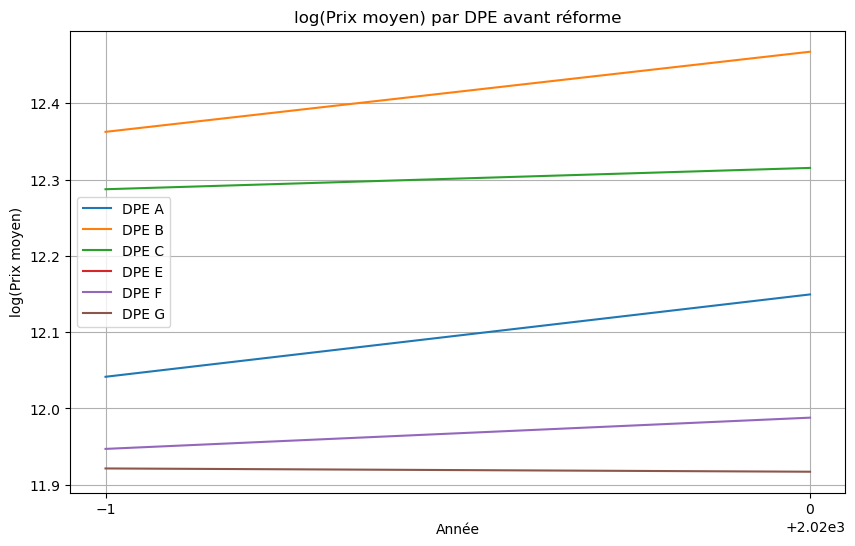

In [19]:
prix_moyen_pre_log = df_mod2[df_mod2['year'] < 2021].copy()
prix_moyen_pre_log['log_prix'] = np.log(prix_moyen_pre_log['valeur_fonciere'])

courbe_log = prix_moyen_pre_log.groupby(['year', 'dpe_clean'])['log_prix'].mean().reset_index()

# Tracer les log(prix)
plt.figure(figsize=(10,6))
for dpe in ['A','B', 'C', 'E', 'F', 'G']:  # enlevant A
    subset = courbe_log[courbe_log['dpe_clean'] == dpe]
    plt.plot(subset['year'], subset['log_prix'], label=f'DPE {dpe}')
plt.xticks(courbe_log['year'].unique())
plt.gca().ticklabel_format(style='plain', axis='x')
plt.title("log(Prix moyen) par DPE avant réforme")
plt.ylabel("log(Prix moyen)")
plt.xlabel("Année")
plt.legend()
plt.grid(True)
plt.show()



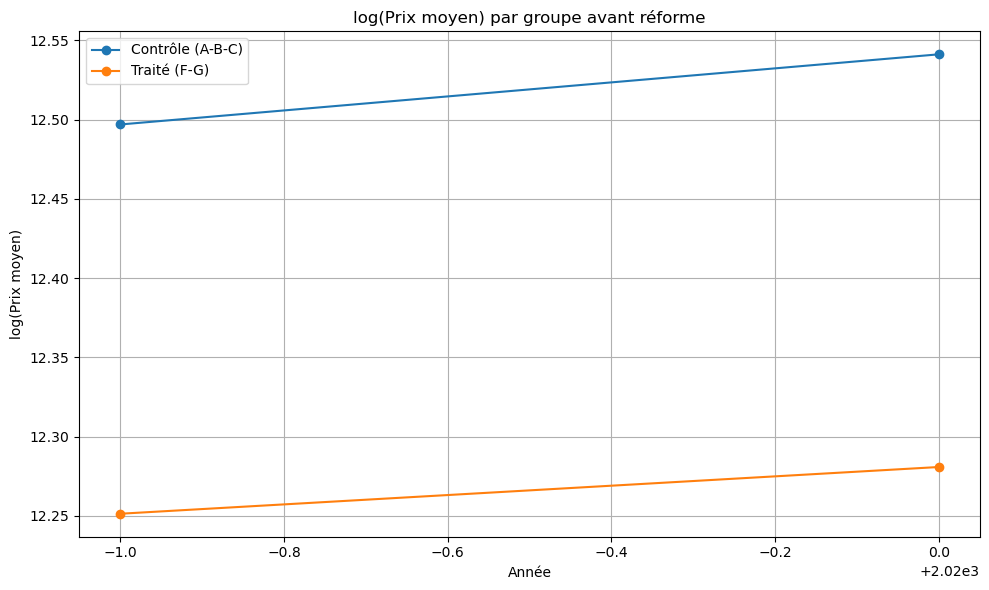

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# On garde seulement les observations avant la réforme
df_pre = df[df['year'] < 2021]

# Moyenne du log(prix) par année et groupe (traité ou non)
grouped = df_pre.groupby(['year', 'treat'])['valeur_fonciere'].mean().reset_index()
grouped['log_prix_moyen'] = np.log(grouped['valeur_fonciere'])
grouped['groupe'] = grouped['treat'].map({0: 'Contrôle (A-B-C)', 1: 'Traité (F-G)'})

# Tracé
plt.figure(figsize=(10, 6))
for label, grp in grouped.groupby('groupe'):
    plt.plot(grp['year'], grp['log_prix_moyen'], marker='o', label=label)

plt.title("log(Prix moyen) par groupe avant réforme")
plt.xlabel("Année")
plt.ylabel("log(Prix moyen)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
print(df.groupby('dpe_clean')['treat'].unique())


dpe_clean
A    [0]
B    [0]
C    [0]
F    [1]
G    [1]
Name: treat, dtype: object


## test pre-trend plus robuste

In [168]:
df_pre = df_mod2[df_mod2['date_mutation'] < '2021-08-24']


Pour vérifier l'hypothèse de tendances parallèles on effectue un test de pré-trend : on regarde si avant la réforme, il y avait déjà une tendance différente entre les deux groupes. Concrètement, on ajoute dans le modèle une ou plusieurs interactions entre les années précédant la réforme et le groupe traité, et on teste si leurs coefficients sont significativement différents de zéro.

In [ ]:
model_pretrend = smf.ols(
    'np.log(valeur_fonciere) ~ C(year) * treat + C(code_departement) + surface_reelle_bati + C(Type_bâtiment) + Année_construction_imp + year_const_miss',
    data=df_pre
).fit(cov_type='cluster', cov_kwds={'groups': df_pre['code_departement']})


In [170]:
model_pretrend.summary()

/usr/local/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 99, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.601
Model:                                 OLS   Adj. R-squared:                  0.600
Method:                      Least Squares   F-statistic:                     8919.
Date:                     Mon, 28 Apr 2025   Prob (F-statistic):          3.79e-126
Time:                             16:41:05   Log-Likelihood:                -9021.6
No. Observations:                    32092   AIC:                         1.824e+04
Df Residuals:                        31992   BIC:                         1.908e+04
Df Model:                               99                                         
Covariance Type:                   cluster                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    10.9878      0.067    163.606      0.000      10.856      11.119
C(year)[T.2020]               0.0384      0.005      7.091      0.000       0.028       0.049
C(year)[T.2021]               0.0844      0.007     12.463      0.000       0.071       0.098
C(code_departement)[T.03]    -0.0636      0.002    -29.945      0.000      -0.068      -0.059
C(code_departement)[T.04]     0.5662      0.004    155.154      0.000       0.559       0.573
C(code_departement)[T.05]     0.5830      0.005    111.198      0.000       0.573       0.593
C(code_departement)[T.07]     0.4500      0.005     86.800      0.000       0.440       0.460
C(code_departement)[T.08]     0.0344      0.001     24.407      0.000       0.032       0.037
C(code_departement)[T.09]    -0.0450      0.006     -6.932      0.000      -0.058      -0.032
C(code_departement)[T.1]      0.4821      0.005     99.793      0.000       0.473       0.492
C(code_departement)[T.10]     0.1466      0.002     73.869      0.000       0.143       0.150
C(code_departement)[T.11]     0.2723      0.008     36.076      0.000       0.257       0.287
C(code_departement)[T.12]     0.2486      0.003     78.537      0.000       0.242       0.255
C(code_departement)[T.13]     0.8528      0.008    112.497      0.000       0.838       0.868
C(code_departement)[T.14]     0.5049      0.004    139.000      0.000       0.498       0.512
C(code_departement)[T.15]     0.0657      0.001     49.456      0.000       0.063       0.068
C(code_departement)[T.16]     0.0321      0.006      5.621      0.000       0.021       0.043
C(code_departement)[T.17]     0.6145      0.006     99.644      0.000       0.602       0.627
C(code_departement)[T.18]     0.0123      0.003      4.849      0.000       0.007       0.017
C(code_departement)[T.19]     0.0922      0.002     39.925      0.000       0.088       0.097
C(code_departement)[T.21]     0.4969      0.002    303.902      0.000       0.494       0.500
C(code_departement)[T.22]     0.2517      0.004     61.501      0.000       0.244       0.260
C(code_departement)[T.23]    -0.2210      0.002   -108.989      0.000      -0.225      -0.217
C(code_departement)[T.24]     0.0673      0.005     14.894      0.000       0.058       0.076
C(code_departement)[T.25]     0.3806      0.002    215.604      0.000       0.377       0.384
C(code_departement)[T.26]     0.4609      0.005     85.280      0.000       0.450       0.472
C(code_departement)[T.27]     0.2898      0.002    120.178      0.000       0.285       0.294
C(code_departement)[T.28]     0.2939      0.002    164.981      0.000       0.290       0.297
C(code_departement)[T.29]     0.3166      0.003    108.848      0.000       0.311       0.322
C(code_departement)[

### est de pré-trend

Dans une régression Diff-in-Diff, l’un des fondements est l’hypothèse de **tendances parallèles** : sans traitement, les groupes traité et contrôle auraient évolué de manière similaire. Pour tester cette hypothèse, on estime un modèle de régression sur la période **précédant la réforme**, avec une interaction entre le groupe traité et les années :

$$
\log(\text{prix}_{it}) = \alpha + \beta_1 \cdot \text{treat}_i + \beta_2 \cdot \text{année}_t + \gamma \cdot (\text{treat}_i \times \text{année}_t) + \text{contrôles} + \varepsilon_{it}
$$

L’objectif est de tester l’hypothèse nulle suivante :

$$
H_0: \gamma = 0
$$

Autrement dit, **aucune différence de tendance** entre les groupes avant la réforme.  
Si ce coefficient $\gamma$ est **non significatif**, cela signifie que les groupes traité et contrôle avaient des trajectoires similaires avant l’intervention → ce qui **valide l’usage du Diff-in-Diff**.

En revanche, si $\gamma$ est **significativement différent de 0**, alors cela suggère que les groupes n’évoluaient pas de manière parallèle avant la réforme. Le Diff-in-Diff risquerait alors d’attribuer à tort l’écart post-réforme au traitement, alors qu’il préexistait.

Dans notre cas, le coefficient d’interaction `C(year)[T.2020]:treat` est de -0.0146 (p = 0.536), ce qui est **non significatif**. Cela **soutient donc l’hypothèse de tendances parallèles** et valide l’approche Diff-in-Diff utilisée par la suite.


# 1ère régression

In [22]:
import statsmodels.formula.api as smf
#commentaire
df_mod2 = df_mod2.copy()
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule du modèle Diff-in-Diff avec variables de contrôle
formula = (
    'np.log(valeur_fonciere) ~ treat + post_exact + did + '
    '+ surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss'
)

# Régression avec erreurs standards robustes clusterisées par département
model = smf.ols(formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
print(model.summary())



                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.139
Model:                                 OLS   Adj. R-squared:                  0.139
Method:                      Least Squares   F-statistic:                     101.5
Date:                     Mon, 28 Apr 2025   Prob (F-statistic):           2.18e-43
Time:                             15:17:11   Log-Likelihood:            -1.1161e+05
No. Observations:                   106682   AIC:                         2.232e+05
Df Residuals:                       106673   BIC:                         2.233e+05
Df Model:                                8                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

hve testtttntest github

# Test de corrélation des variables

In [141]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sélection des variables numériques pour le VIF (sans les variables catégorielles comme code_type_local)
X_vif = df_mod2[[
    'treat',
    'post_exact',
    'did',
    'surface_reelle_bati',
    'Année_construction_imp',
    'year_const_miss'
]]

# Ajout de la constante (intercept)
X_vif = sm.add_constant(X_vif)

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


                 Variable        VIF
0                   const  99.945359
1                   treat   3.444574
2              post_exact   3.557806
3                     did   5.212087
4     surface_reelle_bati   1.030160
5  Année_construction_imp   1.016473
6         year_const_miss   1.142972


In [31]:
df_mod2['dpe_clean'].value_counts()



dpe_clean
D    201131
C    108333
F     61427
G     29991
B     13336
A      5921
Name: count, dtype: int64

## 2e régression : effet fixes

In [ ]:
import statsmodels.formula.api as smf

# S'assurer que 'code_departement' est bien une chaîne
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule avec effets fixes par département et année
formula = (
    'np.log(valeur_fonciere) ~  did + '
    'C(code_departement) + C(year) + '
    'surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss'
)

# Régression avec erreurs standards clusterisées par département
model_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
model_fe.summary()

#test pour githu


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.266
Model:                                 OLS   Adj. R-squared:                  0.266
Method:                      Least Squares   F-statistic:                     283.3
Date:                     Mon, 28 Apr 2025   Prob (F-statistic):           3.11e-63
Time:                             17:04:21   Log-Likelihood:                -64728.
No. Observations:                   105323   AIC:                         1.295e+05
Df Residuals:                       105314   BIC:                         1.296e+05
Df Model:                                8                                         
Covariance Type:                   cluster                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.1491      0.158     70.784      0.000      10.840      11.458
C(year)[T.2020]            0.0379      0.005      6.901      0.000       0.027       0.049
C(year)[T.2021]            0.1312      0.009     15.108      0.000       0.114       0.148
C(year)[T.2022]            0.1683      0.013     13.308      0.000       0.144       0.193
C(year)[T.2023]            0.1871      0.015     12.162      0.000       0.157       0.217
did                       -0.2865      0.025    -11.597      0.000      -0.335      -0.238
surface_reelle_bati        0.0082      0.000     41.640      0.000       0.008       0.009
Année_construction_imp     0.0001   6.64e-05      2.217      0.027    1.71e-05       0.000
year_const_miss           -0.0732      0.014     -5.137      0.000      -0.101      -0.045
==============================================================================
Omnibus:                      317.705   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.331
Skew:                          -0.094   Prob(JB):                     1.14e-77
Kurtosis:                       3.214   Cond. No.                     4.77e+04
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 4.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [171]:


print(f"Nombre de départements uniques : {df_mod2['code_departement'].nunique()}")
print(f"Nombre d'années uniques : {df_mod2['year'].nunique()}")

Nombre de départements uniques : 97
Nombre d'années uniques : 5


## 3e régression : effets fixes plus fins

In [143]:
# Créer une nouvelle variable d'interaction département × année
df_mod2['dep_year'] = df_mod2['code_departement'].astype(str) + "_" + df_mod2['year'].astype(str)


In [144]:
import statsmodels.formula.api as smf

# Formule avec effets fixes croisés département × année
formula = (
    'np.log(valeur_fonciere) ~ treat + did + '
    'C(dep_year) + '
    'surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss'
)

# Estimation avec erreurs standards clusterisées par département
model_cross_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

print(model_cross_fe.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 471, but rank is 7
  warnings.warn('covariance of constraints does not have full '


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.409
Model:                                 OLS   Adj. R-squared:                  0.409
Method:                      Least Squares   F-statistic:                     2910.
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):          8.55e-109
Time:                             15:55:52   Log-Likelihood:            -3.8605e+05
No. Observations:                   373091   AIC:                         7.730e+05
Df Residuals:                       372619   BIC:                         7.781e+05
Df Model:                              471                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [115]:
taux_macro = pd.DataFrame({
    "year": [2019, 2020, 2021, 2022, 2023],
    "inflation": [1.1, 0.5, 1.6, 5.2, 4.9],  # % annuel
    "taux_interet": [1.2, 1.3, 1.4, 2.0, 3.0]  # taux moyen de prêt immo
})

## 4e régression : inclusion des variables de contrôle économiques

In [116]:
df_mod2 = df_mod2.merge(taux_macro, on="year", how="left")


In [118]:
import statsmodels.formula.api as smf

df_mod2 = df_mod2.copy()
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule du modèle Diff-in-Diff avec variables de contrôle
formula = (
    'np.log(valeur_fonciere) ~ treat + post_exact + did + '
    '+ surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss+'
    'inflation + taux_interet'
)

# Régression avec erreurs standards robustes clusterisées par département
model = smf.ols(formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.117
Model:                                 OLS   Adj. R-squared:                  0.117
Method:                      Least Squares   F-statistic:                     48.86
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):           2.94e-33
Time:                             15:32:31   Log-Likelihood:            -1.3944e+05
No. Observations:                   110675   AIC:                         2.789e+05
Df Residuals:                       110664   BIC:                         2.790e+05
Df Model:                               10                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [119]:
import statsmodels.formula.api as smf

# S'assurer que 'code_departement' est bien une chaîne
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule avec effets fixes par département et année
formula = (
    'np.log(valeur_fonciere) ~ treat + did + '
    'C(code_departement) + C(year) + '
    'surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss +'
    'inflation + taux_interet'
)

# Régression avec erreurs standards clusterisées par département
model_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
print(model_fe.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 109, but rank is 11
  warnings.warn('covariance of constraints does not have full '


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.397
Model:                                 OLS   Adj. R-squared:                  0.396
Method:                      Least Squares   F-statistic:                -3.004e+14
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):               1.00
Time:                             15:35:29   Log-Likelihood:            -1.1835e+05
No. Observations:                   110675   AIC:                         2.369e+05
Df Residuals:                       110567   BIC:                         2.379e+05
Df Model:                              107                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [120]:
# 1) Garder uniquement les DPE A à C et E à G
df_mod2 = df_mod2[df_mod2['dpe_clean'].isin(['A', 'B', 'C', 'E', 'F', 'G'])]

# 2) Créer la variable 'treat' pour le groupe traité (E, F, G)
df_mod2['treat'] = df_mod2['dpe_clean'].isin(['E', 'F', 'G']).astype(int)

# 3) Créer la variable 'post_exact' pour les observations après la loi (24 août 2021)
df_mod2['post_exact'] = (df_mod2['date_mutation'] >= '2021-08-24').astype(int)

# 4) Créer l'interaction DID
df_mod2['did'] = df_mod2['treat'] * df_mod2['post_exact']

# 5) Régression DID
formula = (
    'np.log(valeur_fonciere) ~ treat + post_exact + did + '
    'surface_reelle_bati + C(Type_bâtiment) + '
    'Année_construction_imp + year_const_miss'
)

model_did = smf.ols(formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

print(model_did.summary())


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.116
Model:                                 OLS   Adj. R-squared:                  0.116
Method:                      Least Squares   F-statistic:                     54.16
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):           2.99e-32
Time:                             15:44:43   Log-Likelihood:            -1.3946e+05
No. Observations:                   110675   AIC:                         2.789e+05
Df Residuals:                       110666   BIC:                         2.790e+05
Df Model:                                8                                         
Covariance Type:                   cluster                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

In [124]:
print("Répartition des étiquettes DPE par groupe treat:")
print(df_mod2.groupby('treat')['dpe_clean'].value_counts())


Répartition des étiquettes DPE par groupe treat:
treat  dpe_clean
0      B            13336
       A             5921
1      F            61427
       G            29991
Name: count, dtype: int64


In [122]:
# 1) Mettre à jour le groupe traité : E, F, G
df_mod2['treat'] = df_mod2['dpe_clean'].isin(['E', 'F', 'G']).astype(int)

# 2) Créer la variable 'control' pour A, B, C
df_mod2['control'] = df_mod2['dpe_clean'].isin(['A', 'B', 'C']).astype(int)

# 3) Filtrer uniquement les DPE A, B, C, E, F, G
df_mod2 = df_mod2[df_mod2['dpe_clean'].isin(['A', 'B', 'C', 'E', 'F', 'G'])]
